## 1. Install Dependencies (Locked Versions)

In [ ]:
print("Installing dependencies with compatible versions...")

!pip install -q --no-cache-dir \
    "numpy==1.26.4" \
    "transformers==4.44.0" \
    "datasets==2.14.0" \
    "albumentations" \
    "evaluate" \
    "Pillow"

## 2. Imports

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import cv2
from pathlib import Path
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import (
    SegformerForSemanticSegmentation, 
    SegformerImageProcessor,
    TrainingArguments,
    Trainer
)

import albumentations as A
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2025-12-07 11:23:20.396320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765106600.417892    1243 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765106600.424255    1243 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla P100-PCIE-16GB


## 3. Dataset Configuration

In [2]:
# Dataset paths
BASE_PATH = "/kaggle/input/blackwalkersanatomy/GynSurg_Anatomy_Dataset"
IMAGE_BASE = os.path.join(BASE_PATH, "ganseg")
MASK_BASE = os.path.join(BASE_PATH, "ganseg_mask")

# Class mapping for gynecological organs
id2label = {
    0: "background",
    1: "uterus",
    2: "fallopian_tube",
    3: "ovary",
}

label2id = {v: k for k, v in id2label.items()}
num_classes = len(id2label)

print(f"Number of classes: {num_classes}")
print(f"Class mapping:")
for class_id, label in id2label.items():
    print(f"  Class {class_id}: {label}")

# Global variable for intensity mapping (will be set after data exploration)
INTENSITY_TO_CLASS = {}

Number of classes: 4
Class mapping:
  Class 0: background
  Class 1: uterus
  Class 2: fallopian_tube
  Class 3: ovary


## 4. Collect Image-Mask Pairs

This section collects all image and mask file pairs from the dataset.

In [3]:
def find_corresponding_frame(mask_path, image_base_dir):
    """
    Find the corresponding frame image for a mask
    
    mask_path: /path/to/ganseg_mask/GANSEG_01/0.mp4_/0_010800_06-00-00_mask.png
    Returns: /path/to/ganseg/GANSEG_01/0.mp4_/0_010800_06-00-00.png (or .jpg)
    """
    mask_filename = os.path.basename(mask_path)
    
    # Get the directory structure
    parts = Path(mask_path).parts
    ganseg_idx = parts.index('ganseg_mask')
    ganseg_id = parts[ganseg_idx + 1]  # e.g., GANSEG_01
    video_folder = parts[ganseg_idx + 2]  # e.g., 0.mp4_
    
    # Construct image directory
    image_dir = os.path.join(image_base_dir, ganseg_id, video_folder)
    
    # Remove '_mask' from filename to get image filename
    image_filename = mask_filename.replace('_mask.png', '.png')
    image_path = os.path.join(image_dir, image_filename)
    
    # Try different extensions if needed
    if not os.path.exists(image_path):
        image_path = image_path.replace('.png', '.jpg')
    if not os.path.exists(image_path):
        image_path = image_path.replace('.jpg', '.jpeg')
    
    return image_path if os.path.exists(image_path) else None

# Collect all mask files
print("Collecting mask files from all GANSEG folders...")
all_mask_paths = []

for ganseg_dir in sorted(os.listdir(MASK_BASE)):
    ganseg_path = os.path.join(MASK_BASE, ganseg_dir)
    if not os.path.isdir(ganseg_path):
        continue
    
    print(f"  Processing {ganseg_dir}...", end=" ")
    folder_mask_count = 0
    
    for video_folder in sorted(os.listdir(ganseg_path)):
        video_path = os.path.join(ganseg_path, video_folder)
        if not os.path.isdir(video_path):
            continue
        
        # Get all mask files in this video folder
        mask_files = glob.glob(os.path.join(video_path, '*_mask.png'))
        all_mask_paths.extend(mask_files)
        folder_mask_count += len(mask_files)
    
    print(f"{folder_mask_count} masks found")

print(f"\nTotal mask files found: {len(all_mask_paths)}")

# Find corresponding images
print("\nMatching images to masks...")
image_paths = []
mask_paths = []
missing_count = 0

for mask_path in tqdm(all_mask_paths):
    image_path = find_corresponding_frame(mask_path, IMAGE_BASE)
    if image_path:
        image_paths.append(image_path)
        mask_paths.append(mask_path)
    else:
        missing_count += 1

print(f"\n✓ Successfully matched {len(image_paths)} image-mask pairs")
if missing_count > 0:
    print(f"✗ {missing_count} masks without corresponding images")

# Show sample paths
if len(image_paths) > 0:
    print(f"\nSample paths:")
    print(f"  Image: {image_paths[0]}")
    print(f"  Mask:  {mask_paths[0]}")

  Processing GANSEG_01... 142 masks found
  Processing GANSEG_02... 48 masks found
  Processing GANSEG_03... 201 masks found
  Processing GANSEG_04... 239 masks found
  Processing GANSEG_05... 95 masks found

Total mask files found: 725

Matching images to masks...


  0%|          | 0/725 [00:00<?, ?it/s]


✓ Successfully matched 725 image-mask pairs

Sample paths:
  Image: /kaggle/input/blackwalkersanatomy/GynSurg_Anatomy_Dataset/ganseg/GANSEG_01/0.mp4_/0_020567_11-25-17.png
  Mask:  /kaggle/input/blackwalkersanatomy/GynSurg_Anatomy_Dataset/ganseg_mask/GANSEG_01/0.mp4_/0_020567_11-25-17_mask.png


## 5. Analyze Mask Intensities

Detect all unique intensity values in the masks to create the intensity-to-class mapping.

In [4]:
if len(image_paths) == 0:
    raise ValueError("No image-mask pairs found! Check dataset structure.")

print("\n" + "="*60)
print("STEP 1: ANALYZING MASK INTENSITIES")
print("="*60)

# Analyze multiple masks to get consistent intensity values
print("\nAnalyzing first 10 masks to detect all intensity values...")
all_intensities = set()

for mask_path in mask_paths[:10]:
    mask = np.array(Image.open(mask_path))
    if len(mask.shape) == 3:
        mask = mask[:,:,0]  # Take first channel if RGB
    all_intensities.update(np.unique(mask))

all_intensities = sorted(list(all_intensities))
print(f"✓ Found {len(all_intensities)} unique intensity values: {all_intensities}")

# Create intensity to class mapping
INTENSITY_TO_CLASS = {intensity: idx for idx, intensity in enumerate(all_intensities)}
print(f"\nIntensity → Class ID mapping:")
for intensity, class_id in INTENSITY_TO_CLASS.items():
    organ_name = id2label.get(class_id, "unknown")
    print(f"  Intensity {intensity:3d} → Class {class_id} ({organ_name})")



STEP 1: ANALYZING MASK INTENSITIES

Analyzing first 10 masks to detect all intensity values...
✓ Found 4 unique intensity values: [0, 85, 170, 255]

Intensity → Class ID mapping:
  Intensity   0 → Class 0 (background)
  Intensity  85 → Class 1 (uterus)
  Intensity 170 → Class 2 (fallopian_tube)
  Intensity 255 → Class 3 (ovary)


## 6. Random Sample Visualization

Visualize a random sample with custom color mapping for each intensity class.


STEP 2: RANDOM SAMPLE VISUALIZATION
Found full-class sample on attempt 41

Selected sample index: 9
Randomly chosen image: 0_019800_11-00-00.png
Randomly chosen mask:  0_019800_11-00-00_mask.png

Intensities in this sample: [  0  85 170 255]

Pixel distribution:
  Intensity   0:  286347 pixels (82.86%)
  Intensity  85:   39289 pixels (11.37%)
  Intensity 170:   19017 pixels ( 5.50%)
  Intensity 255:     947 pixels ( 0.27%)


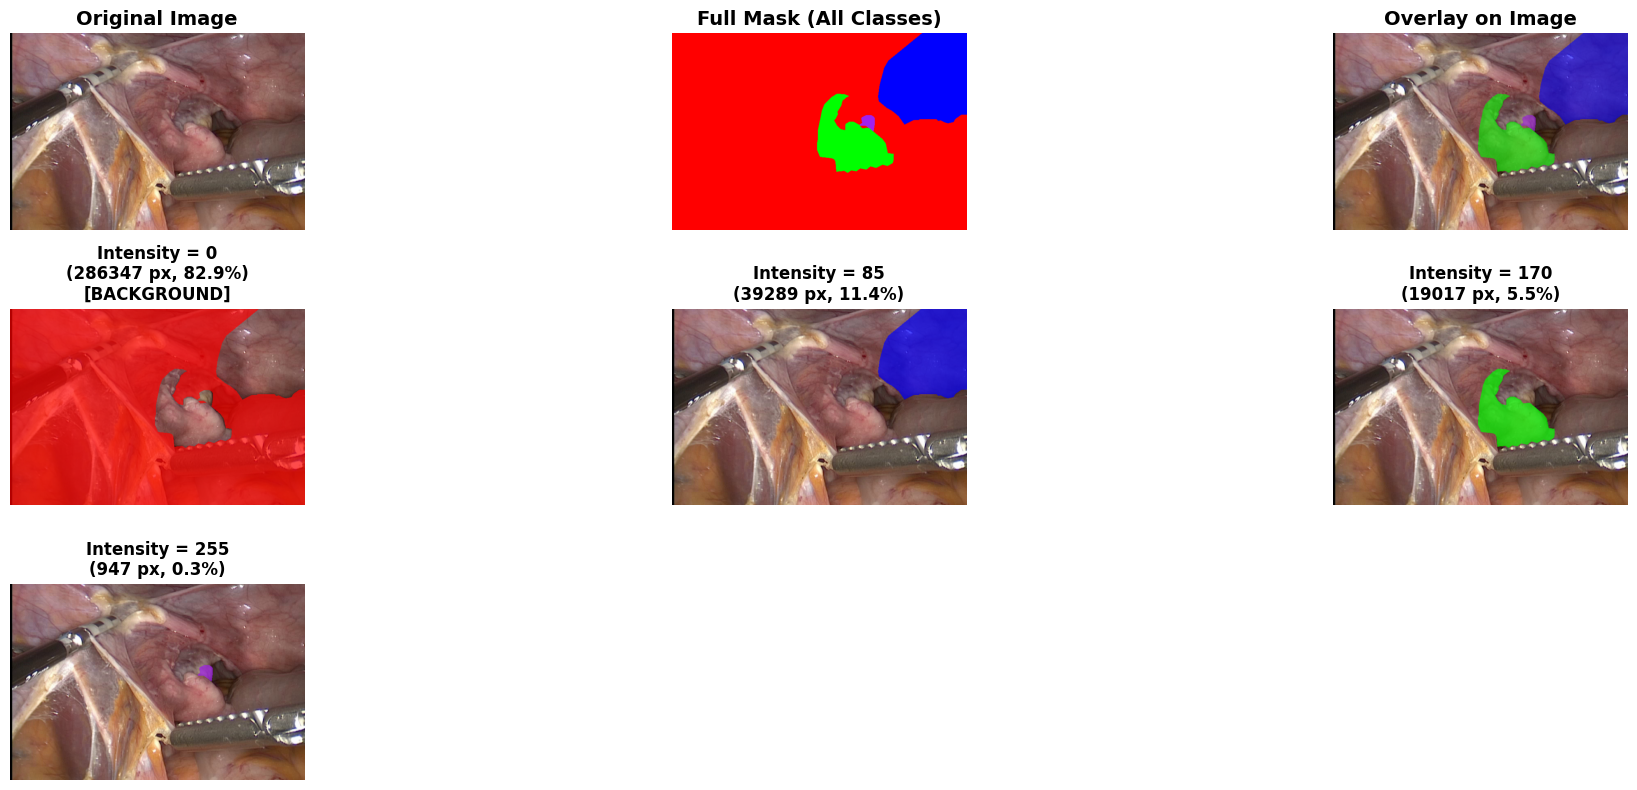


👆 RANDOM VISUALIZATION COMPLETE


In [5]:
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

print("\n" + "="*60)
print("STEP 2: RANDOM SAMPLE VISUALIZATION")
print("="*60)

# All available intensities you expect
EXPECTED_CLASSES = {0, 85, 170, 255}

# ---- CUSTOM COLOR MAP FOR YOUR CLASSES ----
# Format: intensity_value : (R, G, B)
COLOR_MAP = {
    0:   np.array([255,   0,   0], dtype=np.uint8),  # background -> red
    85:  np.array([  0,   0, 255], dtype=np.uint8),  # uterus     -> blue
    170: np.array([  0, 255,   0], dtype=np.uint8),  # tube       -> green
    255: np.array([160,  32, 240], dtype=np.uint8),  # ovary      -> purple
}

# Try up to 50 random samples to find one with max classes
max_intensities = 0
best_mask_idx = None

for attempt in range(50):
    idx = random.randint(0, len(mask_paths) - 1)  # random index
    mask = np.array(Image.open(mask_paths[idx]))

    if len(mask.shape) == 3:
        mask = mask[:, :, 0]

    vals = set(np.unique(mask))
    if len(vals) > max_intensities:
        max_intensities = len(vals)
        best_mask_idx = idx

    # if all classes appear, stop early
    if EXPECTED_CLASSES.issubset(vals):
        print(f"Found full-class sample on attempt {attempt+1}")
        break

print(f"\nSelected sample index: {best_mask_idx}")
sample_img_path = image_paths[best_mask_idx]
sample_mask_path = mask_paths[best_mask_idx]

print(f"Randomly chosen image: {os.path.basename(sample_img_path)}")
print(f"Randomly chosen mask:  {os.path.basename(sample_mask_path)}\n")

img = Image.open(sample_img_path).convert('RGB')
mask = Image.open(sample_mask_path)
mask_array = np.array(mask)

# Handle RGB mask
if len(mask_array.shape) == 3:
    mask_array = mask_array[:, :, 0]
    print("Converted RGB mask → grayscale channel\n")

unique_values = np.unique(mask_array)
print(f"Intensities in this sample: {unique_values}\n")

# Pixel distribution
print("Pixel distribution:")
for val in unique_values:
    count = np.sum(mask_array == val)
    percentage = (count / mask_array.size) * 100
    print(f"  Intensity {val:3d}: {count:7d} pixels ({percentage:5.2f}%)")

# ---------------- VISUALIZATION ----------------
n_intensities = len(unique_values)
fig = plt.figure(figsize=(20, 4 * ((n_intensities + 2) // 3)))

# Original image
ax1 = plt.subplot(((n_intensities + 2) // 3) + 1, 3, 1)
ax1.imshow(img)
ax1.set_title("Original Image", fontsize=14, fontweight='bold')
ax1.axis('off')

# Full mask view with *manual* colors
ax2 = plt.subplot(((n_intensities + 2) // 3) + 1, 3, 2)
h, w = mask_array.shape
color_mask = np.zeros((h, w, 3), dtype=np.uint8)

for val in unique_values:
    color = COLOR_MAP.get(int(val), np.array([0, 0, 0], dtype=np.uint8))
    color_mask[mask_array == val] = color

ax2.imshow(color_mask)
ax2.set_title("Full Mask (All Classes)", fontsize=14, fontweight='bold')
ax2.axis('off')

# Overlay view using the same COLOR_MAP
ax3 = plt.subplot(((n_intensities + 2) // 3) + 1, 3, 3)
img_array = np.array(img)
overlay = img_array.copy()
for val in unique_values:
    if val == 0:
        continue
    mask_bool = mask_array == val
    if not np.any(mask_bool):
        continue
    color_rgb = COLOR_MAP.get(int(val), np.array([0, 0, 0], dtype=np.uint8))
    overlay[mask_bool] = (overlay[mask_bool] * 0.4 + color_rgb * 0.6).astype(np.uint8)

ax3.imshow(overlay)
ax3.set_title("Overlay on Image", fontsize=14, fontweight='bold')
ax3.axis('off')

# Individual class visualizations
for idx, intensity_val in enumerate(unique_values):
    ax = plt.subplot(((n_intensities + 2) // 3) + 1, 3, idx + 4)

    colored_img = img_array.copy()
    mask_bool = mask_array == intensity_val

    if np.any(mask_bool):
        color_rgb = COLOR_MAP.get(int(intensity_val), np.array([0, 0, 0], dtype=np.uint8))
        colored_img[mask_bool] = (colored_img[mask_bool] * 0.3 + color_rgb * 0.7).astype(np.uint8)

    ax.imshow(colored_img)
    pixel_count = np.sum(mask_array == intensity_val)
    perc = (pixel_count / mask_array.size) * 100

    title = f"Intensity = {intensity_val}\n({pixel_count} px, {perc:.1f}%)"
    if intensity_val == 0:
        title += "\n[BACKGROUND]"

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("👆 RANDOM VISUALIZATION COMPLETE")
print("="*60)


## 7. Prepare Train-Validation Split

Split the dataset by video groups to avoid data leakage.

In [6]:
print("\n" + "="*60)
print("PREPARING TRAIN-VALIDATION SPLIT")
print("="*60)

# Group by GANSEG folder and video to avoid data leakage
video_groups = []
for mask_path in mask_paths:
    parts = Path(mask_path).parts
    ganseg_id = parts[parts.index('ganseg_mask') + 1]
    video_folder = parts[parts.index('ganseg_mask') + 2]
    video_groups.append(f"{ganseg_id}_{video_folder}")

# Convert to dataframe for easier splitting
df = pd.DataFrame({
    'image_path': image_paths,
    'mask_path': mask_paths,
    'video_group': video_groups
})

print(f"\nDataset statistics:")
print(f"  Total samples: {len(df)}")
print(f"  Unique video groups: {df['video_group'].nunique()}")

print(f"\nSamples per video group:")
group_counts = df['video_group'].value_counts()
for group, count in group_counts.items():
    print(f"  {group}: {count} frames")

# Split by video group to avoid leakage
unique_groups = df['video_group'].unique()
train_groups, val_groups = train_test_split(
    unique_groups, 
    test_size=0.2, 
    random_state=42
)

train_df = df[df['video_group'].isin(train_groups)]
val_df = df[df['video_group'].isin(val_groups)]

train_images = train_df['image_path'].tolist()
train_masks = train_df['mask_path'].tolist()
val_images = val_df['image_path'].tolist()
val_masks = val_df['mask_path'].tolist()

print(f"\n✓ Split complete:")
print(f"  Training samples: {len(train_images)} ({len(train_images)/len(df)*100:.1f}%)")
print(f"  Validation samples: {len(val_images)} ({len(val_images)/len(df)*100:.1f}%)")
print(f"\nTraining video groups: {sorted(train_groups)}")
print(f"Validation video groups: {sorted(val_groups)}")


PREPARING TRAIN-VALIDATION SPLIT

Dataset statistics:
  Total samples: 725
  Unique video groups: 23

Samples per video group:
  GANSEG_01_1.mp4_: 82 frames
  GANSEG_04_1.mp4_: 75 frames
  GANSEG_03_1.mp4_: 75 frames
  GANSEG_04_0.mp4_: 54 frames
  GANSEG_04_4.mp4_: 53 frames
  GANSEG_05_1.mp4_: 53 frames
  GANSEG_02_0.mp4_: 48 frames
  GANSEG_03_2.mp4_: 36 frames
  GANSEG_03_0.mp4_: 32 frames
  GANSEG_03_4.mp4_: 32 frames
  GANSEG_01_2.mp4_: 30 frames
  GANSEG_04_3.mp4_: 29 frames
  GANSEG_05_0.mp4_: 25 frames
  GANSEG_01_0.mp4_: 22 frames
  GANSEG_03_3.mp4_: 21 frames
  GANSEG_05_2.mp4_: 17 frames
  GANSEG_04_2.mp4_: 12 frames
  GANSEG_04_6.mp4_: 9 frames
  GANSEG_01_3.mp4_: 7 frames
  GANSEG_04_5.mp4_: 7 frames
  GANSEG_03_6.mp4_: 3 frames
  GANSEG_03_5.mp4_: 2 frames
  GANSEG_01_4.mp4_: 1 frames

✓ Split complete:
  Training samples: 581 (80.1%)
  Validation samples: 144 (19.9%)

Training video groups: ['GANSEG_01_1.mp4_', 'GANSEG_01_2.mp4_', 'GANSEG_01_3.mp4_', 'GANSEG_01_4.mp4_'

## 8. Dataset Class

Custom PyTorch Dataset for loading and preprocessing images and masks.

In [7]:
# Global mapping: raw mask intensities → class IDs
# 0=bg, 85=uterus, 170=tube, 255=ovary
INTENSITY_TO_CLASS = {
    0:   0,  # background
    85:  1,  # uterus
    170: 2,  # fallopian_tube
    255: 3,  # ovary
}

class GynSurgDataset(Dataset):
    """Dataset for gynecological surgery segmentation"""
    
    def __init__(self, image_paths, mask_paths, processor, 
                 target_size=512, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor
        self.target_size = target_size
        self.augment = augment
        
        # Augmentation pipeline for training
        if augment:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.3),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, 
                                   rotate_limit=15, p=0.5),
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, 
                                     val_shift_limit=10, p=0.3),
            ])
        else:
            self.transform = None
    
    def mask_to_class_ids(self, mask):
        """
        Convert grayscale mask intensities (0,85,170,255) to class IDs (0,1,2,3).
        Uses the global INTENSITY_TO_CLASS mapping.
        """
        mask = np.array(mask)
        
        # Handle RGB masks by taking first channel
        if len(mask.shape) == 3:
            mask = mask[:, :, 0]
        
        # IMPORTANT: Keep original size, don't resize here
        h, w = mask.shape
        class_mask = np.zeros((h, w), dtype=np.int64)
        
        # Map each intensity to its class ID
        for intensity, class_id in INTENSITY_TO_CLASS.items():
            class_mask[mask == intensity] = class_id
        
        return class_mask
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = np.array(image)
        
        # Load and convert mask - KEEP ORIGINAL SIZE
        mask = Image.open(self.mask_paths[idx])
        mask = self.mask_to_class_ids(mask)
        
        # Apply augmentation (both image and mask at same size)
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
        
        # Process image with SegFormer processor (this resizes to target_size)
        encoded = self.processor(
            images=image,
            return_tensors="pt"
        )
        
        # Resize mask to match processor's target size using nearest neighbor
        mask_tensor = torch.from_numpy(mask.astype(np.int64))
        mask_tensor = mask_tensor.unsqueeze(0).unsqueeze(0).float()  # (1, 1, H, W)
        
        mask_resized = F.interpolate(
            mask_tensor, 
            size=(self.target_size, self.target_size), 
            mode="nearest"
        )
        mask_resized = mask_resized.squeeze(0).squeeze(0).long()  # (H, W)
        
        # Prepare output
        encoded_inputs = {k: v.squeeze(0) for k, v in encoded.items()}
        encoded_inputs["labels"] = mask_resized
        
        return encoded_inputs


## 9. Initialize Model and Processor

Load the SegFormer model and image processor from Hugging Face.

In [8]:
MODEL_NAME = "nvidia/segformer-b1-finetuned-ade-512-512"
# For better accuracy, try: "nvidia/segformer-b1-finetuned-ade-512-512"

print("Loading SegFormer model and processor...")
print(f"Model: {MODEL_NAME}")

# Initialize processor
processor = SegformerImageProcessor.from_pretrained(MODEL_NAME)

# Initialize model
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Model loaded successfully")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

Loading SegFormer model and processor...
Model: nvidia/segformer-b1-finetuned-ade-512-512


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.9M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([4, 256, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model loaded successfully
  Total parameters: 13,678,276
  Trainable parameters: 13,678,276


## 10. Create Datasets and DataLoaders

Create training and validation datasets with augmentation.

Creating datasets...
✓ Datasets created:
  Train dataset: 581 samples
  Val dataset: 144 samples

Testing dataset loading on a random sample...
  Random sample index: 44
  pixel_values shape: torch.Size([3, 512, 512])
  labels shape: torch.Size([512, 512])
  labels unique values: [0, 1, 3]
✓ Dataset loading successful


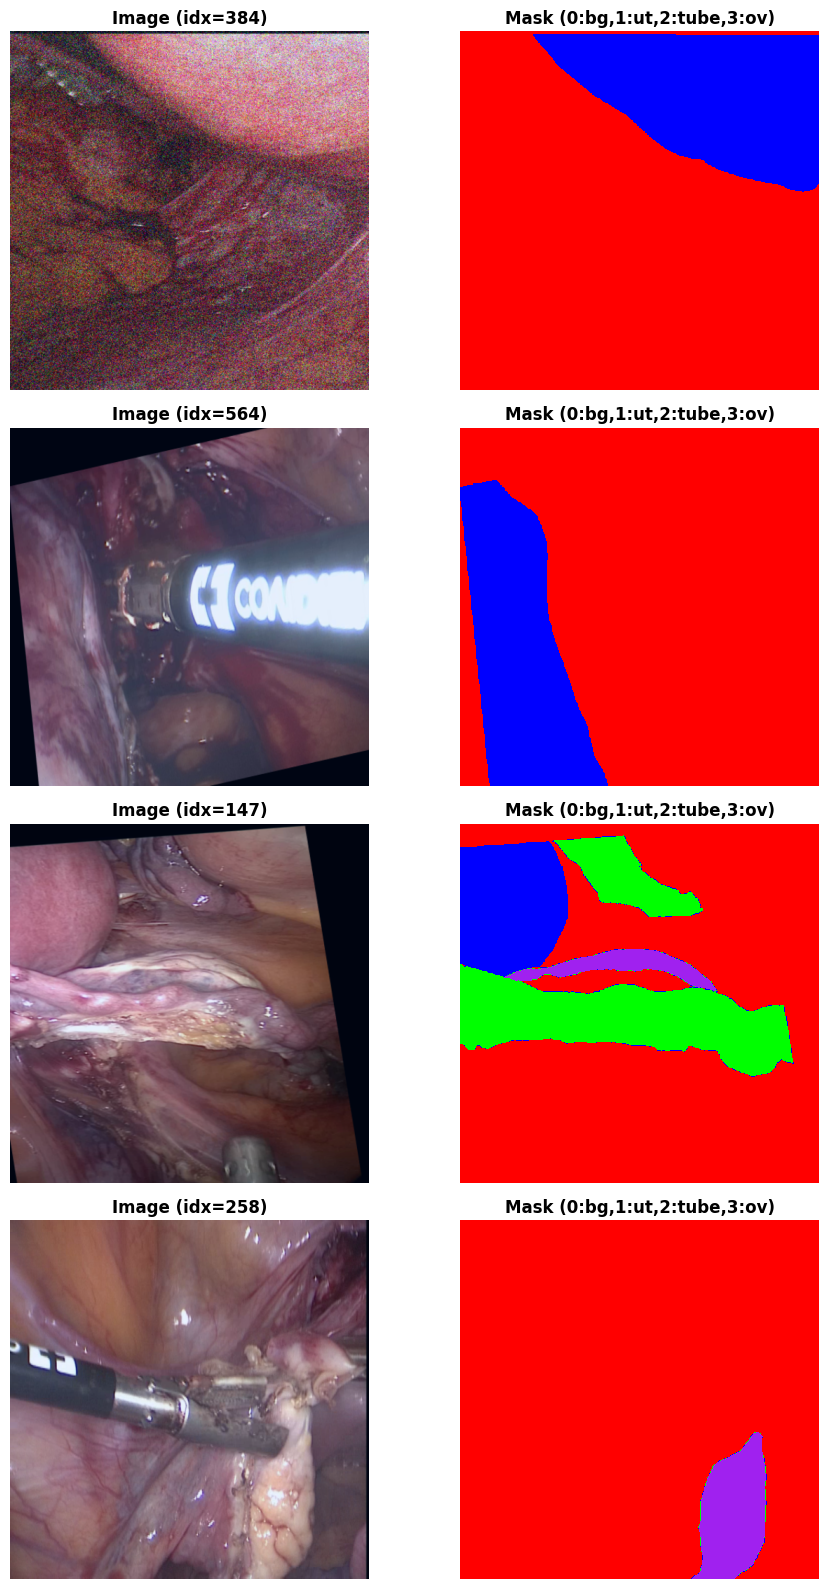

In [9]:
TARGET_SIZE = 512
num_classes = 4  # 0:bg, 1:uterus, 2:tube, 3:ovary

print("Creating datasets...")

train_dataset = GynSurgDataset(
    train_images, 
    train_masks, 
    processor,
    target_size=TARGET_SIZE,
    augment=True  # Enable augmentation for training
)

val_dataset = GynSurgDataset(
    val_images, 
    val_masks, 
    processor,
    target_size=TARGET_SIZE,
    augment=False  # No augmentation for validation
)

print(f"✓ Datasets created:")
print(f"  Train dataset: {len(train_dataset)} samples")
print(f"  Val dataset: {len(val_dataset)} samples")

# ------------------ TEST ONE RANDOM SAMPLE ------------------

from matplotlib.colors import ListedColormap
import random

# Class IDs: 0=bg, 1=uterus, 2=tube, 3=ovary
# Colors: bg=red, uterus=blue, tube=green, ovary=purple
CLASS_COLORS = np.array([
    [1.0, 0.0, 0.0],   # 0 - background (red)
    [0.0, 0.0, 1.0],   # 1 - uterus (blue)
    [0.0, 1.0, 0.0],   # 2 - fallopian_tube (green)
    [0.63, 0.13, 0.94] # 3 - ovary (purple)
])
class_cmap = ListedColormap(CLASS_COLORS)

print("\nTesting dataset loading on a random sample...")

rand_idx = random.randint(0, len(train_dataset) - 1)
sample = train_dataset[rand_idx]
print(f"  Random sample index: {rand_idx}")
print(f"  pixel_values shape: {sample['pixel_values'].shape}")
print(f"  labels shape: {sample['labels'].shape}")
print(f"  labels unique values: {torch.unique(sample['labels']).tolist()}")
print("✓ Dataset loading successful")

# ------------------ VISUALIZE MULTIPLE RANDOM SAMPLES ------------------

num_show = 4  # how many examples to show
indices = random.sample(range(len(train_dataset)), k=min(num_show, len(train_dataset)))

fig, axes = plt.subplots(len(indices), 2, figsize=(10, 4 * len(indices)))

# Ensure axes is 2D [row, col]
if len(indices) == 1:
    axes = np.expand_dims(axes, axis=0)

for row, idx in enumerate(indices):
    s = train_dataset[idx]
    img_tensor = s["pixel_values"]          # (3, H, W)
    mask_tensor = s["labels"]               # (H, W)

    # Convert image back to [0,1] for visualization
    img_np = img_tensor.numpy().transpose(1, 2, 0)
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    # Show image
    axes[row, 0].imshow(img_np)
    axes[row, 0].set_title(f"Image (idx={idx})", fontsize=12, fontweight='bold')
    axes[row, 0].axis('off')

    # Show mask with custom colormap
    axes[row, 1].imshow(mask_tensor.numpy(), cmap=class_cmap, vmin=0, vmax=num_classes-1)
    axes[row, 1].set_title("Mask (0:bg,1:ut,2:tube,3:ov)", fontsize=12, fontweight='bold')
    axes[row, 1].axis('off')

plt.tight_layout()
plt.show()


## 11. Metrics

Define IoU and Dice coefficient metrics for evaluation.

In [10]:
def compute_iou(preds, labels, num_classes):
    """Compute mean IoU across all classes"""
    ious = []
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        label_mask = (labels == cls)
        
        intersection = np.logical_and(pred_mask, label_mask).sum()
        union = np.logical_or(pred_mask, label_mask).sum()
        
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        ious.append(iou)
    
    return np.nanmean(ious)

def compute_dice(preds, labels, num_classes):
    """Compute mean Dice coefficient"""
    dices = []
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        label_mask = (labels == cls)
        
        intersection = np.logical_and(pred_mask, label_mask).sum()
        dice = (2. * intersection) / (pred_mask.sum() + label_mask.sum() + 1e-8)
        dices.append(dice)
    
    return np.mean(dices)

def compute_per_class_metrics(preds, labels, num_classes):
    """Compute IoU and Dice for each class"""
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    
    metrics = {}
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        label_mask = (labels == cls)
        
        intersection = np.logical_and(pred_mask, label_mask).sum()
        union = np.logical_or(pred_mask, label_mask).sum()
        
        if union > 0:
            iou = intersection / union
            dice = (2. * intersection) / (pred_mask.sum() + label_mask.sum() + 1e-8)
        else:
            iou = float('nan')
            dice = float('nan')
        
        metrics[f"class_{cls}_iou"] = iou
        metrics[f"class_{cls}_dice"] = dice
    
    return metrics

print("✓ Metric functions defined")

✓ Metric functions defined


## 12. Training Configuration

Set up training hyperparameters and arguments.

In [11]:
OUTPUT_DIR = "./segformer-gynsurg-b1"
BATCH_SIZE = 4  # Reduce to 2 if OOM
NUM_EPOCHS = 100
LEARNING_RATE = 5e-5
WARMUP_STEPS = 100

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    logging_steps=10,
    logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_iou",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="none",
)

print("Training configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Image size: {TARGET_SIZE}x{TARGET_SIZE}")
print(f"  FP16 training: {torch.cuda.is_available()}")
print(f"  Output directory: {OUTPUT_DIR}")

Training configuration:
  Model: nvidia/segformer-b1-finetuned-ade-512-512
  Batch size: 4
  Epochs: 100
  Learning rate: 5e-05
  Image size: 512x512
  FP16 training: True
  Output directory: ./segformer-gynsurg-b1


## 13. Custom Trainer

Custom trainer with IoU/Dice metrics for evaluation.

In [12]:
def soft_dice_loss(logits, labels, num_classes, eps=1e-6):
    """
    logits: (B, C, H, W)
    labels: (B, H, W) with values in [0, C-1]
    """
    # Convert logits to probabilities
    probs = F.softmax(logits, dim=1)  # (B, C, H, W)

    # One-hot encode labels
    labels_one_hot = F.one_hot(labels, num_classes=num_classes)  # (B, H, W, C)
    labels_one_hot = labels_one_hot.permute(0, 3, 1, 2).float()  # (B, C, H, W)

    # Optionally ignore background in dice (class 0)
    # Here we'll include all classes:
    dims = (0, 2, 3)  # sum over batch, H, W

    intersection = torch.sum(probs * labels_one_hot, dims)
    cardinality = torch.sum(probs + labels_one_hot, dims)

    dice_per_class = (2.0 * intersection + eps) / (cardinality + eps)
    # Mean over classes
    dice_loss = 1.0 - dice_per_class.mean()
    return dice_loss

In [13]:
from transformers import Trainer
from transformers.trainer_utils import EvalLoopOutput

class SegmentationTrainer(Trainer):
    """Custom trainer with IoU/Dice metrics"""
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """Compute loss"""
        labels = inputs.pop("labels")            # (B, H, W)
        outputs = model(**inputs)                # logits at low res
        logits = outputs.logits
        
        # Upsample logits to match label size
        upsampled_logits = F.interpolate(
            logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        
        # Cross-entropy loss
        ce_loss = F.cross_entropy(upsampled_logits, labels, ignore_index=-100)

        # Dice loss (on the same upsampled logits)
        dice_loss = soft_dice_loss(upsampled_logits, labels, num_classes)

        # Combine them (you can tune the weight 0.5)
        loss = ce_loss + 0.5 * dice_loss
        
        return (loss, outputs) if return_outputs else loss
    
    def evaluation_loop(
        self, 
        dataloader, 
        description: str, 
        prediction_loss_only: bool = None, 
        ignore_keys=None, 
        metric_key_prefix: str = "eval",
    ):
        """Custom evaluation with IoU and Dice"""
        model = self.model
        model.eval()
        
        total_loss = 0.0
        total_iou = 0.0
        total_dice = 0.0
        num_batches = 0
        
        # Per-class accumulators
        per_class_iou = np.zeros(num_classes, dtype=np.float64)
        per_class_dice = np.zeros(num_classes, dtype=np.float64)
        per_class_count = np.zeros(num_classes, dtype=np.float64)
        
        with torch.no_grad():
            for batch in tqdm(dataloader, desc=description):
                pixel_values = batch["pixel_values"].to(model.device)
                labels = batch["labels"].to(model.device)        # (B, H, W)
                
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits                          # (B, C, h, w)
                
                # Upsample to label size
                upsampled_logits = F.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
                
                loss = F.cross_entropy(upsampled_logits, labels, ignore_index=-100)
                
                # Predictions
                preds = upsampled_logits.argmax(dim=1)           # (B, H, W)
                
                # Overall metrics
                iou = compute_iou(preds, labels, num_classes)
                dice = compute_dice(preds, labels, num_classes)
                
                # Per-class metrics
                class_metrics = compute_per_class_metrics(preds, labels, num_classes)
                for cls in range(num_classes):
                    iou_val = class_metrics[f"class_{cls}_iou"]
                    dice_val = class_metrics[f"class_{cls}_dice"]
                    if not np.isnan(iou_val):
                        per_class_iou[cls] += iou_val
                        per_class_dice[cls] += dice_val
                        per_class_count[cls] += 1
                
                total_loss += loss.item()
                total_iou += iou
                total_dice += dice
                num_batches += 1
        
        # Aggregate metrics
        metrics = {
            f"{metric_key_prefix}_loss": total_loss / num_batches,
            f"{metric_key_prefix}_iou": total_iou / num_batches,
            f"{metric_key_prefix}_dice": total_dice / num_batches,
        }
        
        # Per-class means
        for cls in range(num_classes):
            if per_class_count[cls] > 0:
                metrics[f"{metric_key_prefix}_iou_{id2label[cls]}"] = (
                    per_class_iou[cls] / per_class_count[cls]
                )
                metrics[f"{metric_key_prefix}_dice_{id2label[cls]}"] = (
                    per_class_dice[cls] / per_class_count[cls]
                )
        
        # IMPORTANT: return EvalLoopOutput, not dict
        return EvalLoopOutput(
            predictions=None,          
            label_ids=None,
            metrics=metrics,
            num_samples=len(dataloader.dataset),
        )

print("✓ Custom trainer defined")


✓ Custom trainer defined


## 14. Train Model

Start the training process.

In [14]:
trainer = SegmentationTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)
print(f"Training on {len(train_dataset)} samples")
print(f"Validating on {len(val_dataset)} samples")
print("="*60 + "\n")

train_result = trainer.train()

print("\n" + "="*60)
print("✓ TRAINING COMPLETED!")
print("="*60)


STARTING TRAINING
Training on 581 samples
Validating on 144 samples



Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/36 [00:00<?, ?it/s]


✓ TRAINING COMPLETED!


## 15. Save Model

Save the trained model and processor.

In [15]:
print("\nSaving model...")
trainer.save_model(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)
print(f"✓ Model saved to {OUTPUT_DIR}")


Saving model...
✓ Model saved to ./segformer-gynsurg-b1


#### Export SegFormer to ONNX

In [ ]:
!pip install onnx onnxruntime onnxruntime-gpu  # gpu version optional
!pip install protobuf==3.20.*                  # avoids ONNX protobuf issues

In [16]:
import torch
from transformers import AutoModelForSemanticSegmentation, AutoImageProcessor
import onnx
import onnxruntime as ort

MODEL_DIR = "./segformer-gynsurg-b1"
ONNX_PATH = f"{MODEL_DIR}/model.onnx"

# Load your trained model + processor
model = AutoModelForSemanticSegmentation.from_pretrained(MODEL_DIR)
processor = AutoImageProcessor.from_pretrained(MODEL_DIR)

model.eval()

# Create dummy input for export
dummy_input = torch.randn(1, 3, TARGET_SIZE, TARGET_SIZE)  # e.g., 512×512

# Export ONNX
torch.onnx.export(
    model,
    (dummy_input,),
    ONNX_PATH,
    input_names=["pixel_values"],
    output_names=["logits"],
    opset_version=17,
    do_constant_folding=True,
    dynamic_axes={
        "pixel_values": {0: "batch", 2: "height", 3: "width"},
        "logits": {0: "batch", 2: "height", 3: "width"},
    },
)

print(f"✓ ONNX model exported to {ONNX_PATH}")

# Validate ONNX file
onnx_model = onnx.load(ONNX_PATH)
onnx.checker.check_model(onnx_model)
print("✓ ONNX model is valid")

# Optional: test inference with ONNX Runtime
ort_session = ort.InferenceSession(ONNX_PATH)
outputs = ort_session.run(None, {"pixel_values": dummy_input.numpy()})
print("ONNX output logits shape:", outputs[0].shape)


✓ ONNX model exported to ./segformer-gynsurg-b1/model.onnx
✓ ONNX model is valid
ONNX output logits shape: (1, 4, 128, 128)


## 16. Inference and Visualization

Visualize model predictions on validation samples.

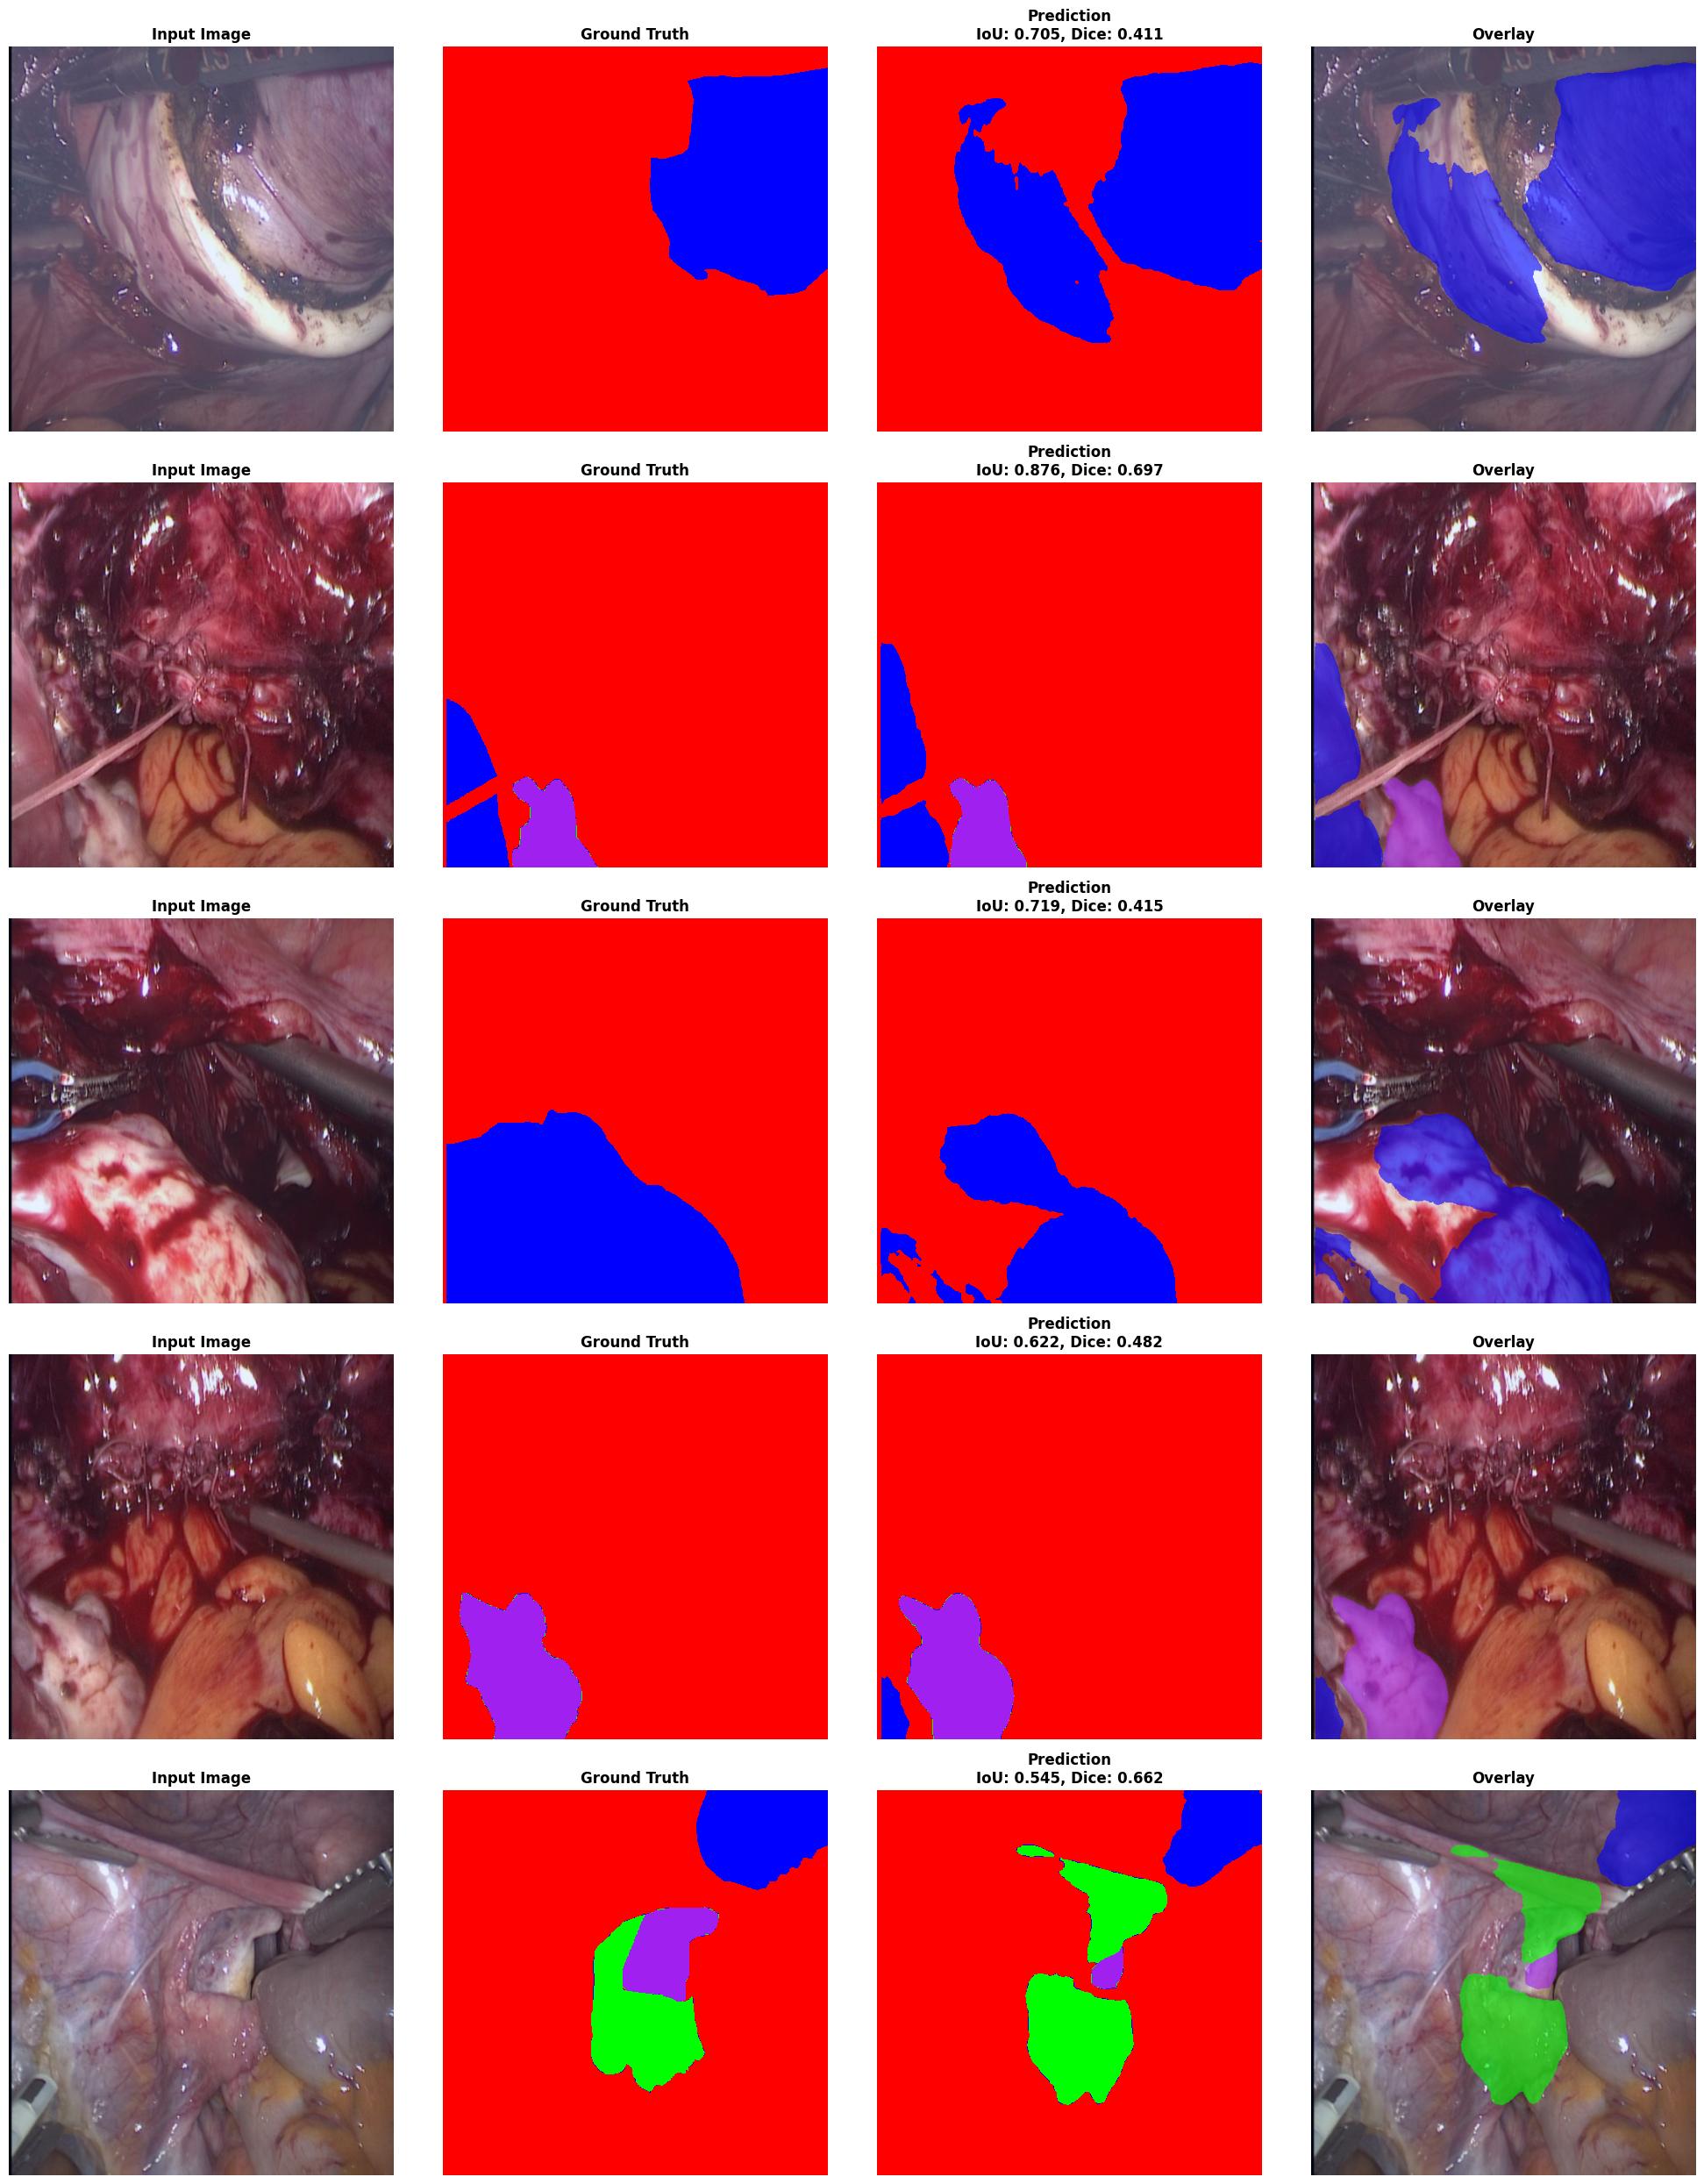

In [22]:
def visualize_predictions(model, dataset, processor, num_samples=5, indices=None):
    """Visualize model predictions with correct class colors"""
    model.eval()
    device = next(model.parameters()).device
    
    # ---------------- CUSTOM COLOR MAP (same as before) ----------------
    # 0=bg, 1=uterus, 2=tube, 3=ovary
    CLASS_COLORS = np.array([
        [1.0, 0.0, 0.0],     # background - red
        [0.0, 0.0, 1.0],     # uterus - blue
        [0.0, 1.0, 0.0],     # fallopian tube - green
        [0.63, 0.13, 0.94],  # ovary - purple
    ])
    class_cmap = ListedColormap(CLASS_COLORS)

    # -------------------------------------------------------------------
    
    if indices is None:
        indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    else:
        num_samples = len(indices)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for idx, sample_idx in enumerate(indices):
            sample = dataset[sample_idx]
            pixel_values = sample["pixel_values"].unsqueeze(0).to(device)
            true_mask = sample["labels"]

            # -------------------- Get Prediction --------------------
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            
            # Upsample to original mask size
            upsampled_logits = F.interpolate(
                logits,
                size=true_mask.shape,
                mode="bilinear",
                align_corners=False
            )
            pred_mask = upsampled_logits.argmax(dim=1).squeeze().cpu()
            
            # -------------------- Prepare Image --------------------
            img = pixel_values.squeeze().cpu().numpy().transpose(1, 2, 0)
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)

            # -------------------- Compute Metrics --------------------
            sample_iou = compute_iou(pred_mask.unsqueeze(0), true_mask.unsqueeze(0), num_classes)
            sample_dice = compute_dice(pred_mask.unsqueeze(0), true_mask.unsqueeze(0), num_classes)
            
            # -------------------- Plot Input Image --------------------
            axes[idx, 0].imshow(img)
            axes[idx, 0].set_title("Input Image", fontsize=12, fontweight='bold')
            axes[idx, 0].axis('off')
            
            # -------------------- Ground Truth Mask --------------------
            axes[idx, 1].imshow(true_mask, cmap=class_cmap, vmin=0, vmax=num_classes-1)
            axes[idx, 1].set_title("Ground Truth", fontsize=12, fontweight='bold')
            axes[idx, 1].axis('off')
            
            # -------------------- Predicted Mask --------------------
            axes[idx, 2].imshow(pred_mask, cmap=class_cmap, vmin=0, vmax=num_classes-1)
            axes[idx, 2].set_title(
                f"Prediction\nIoU: {sample_iou:.3f}, Dice: {sample_dice:.3f}",
                fontsize=12, fontweight='bold'
            )
            axes[idx, 2].axis('off')

            # -------------------- Overlay --------------------
            img_uint8 = (img * 255).astype(np.uint8)
            overlay = img_uint8.copy()

            for cls in range(1, num_classes):  # skip background
                mask_bool = (pred_mask.numpy() == cls)
                if np.any(mask_bool):
                    rgb = (CLASS_COLORS[cls] * 255).astype(np.uint8)
                    overlay[mask_bool] = (
                        overlay[mask_bool] * 0.4 + rgb * 0.6
                    ).astype(np.uint8)

            axes[idx, 3].imshow(overlay)
            axes[idx, 3].set_title("Overlay", fontsize=12, fontweight='bold')
            axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
visualize_predictions(model, val_dataset, processor, num_samples=5)

## 17. Final Evaluation Metrics

Compute comprehensive metrics on the validation set.

In [19]:
print("\n" + "="*60)
print("FINAL EVALUATION ON VALIDATION SET")
print("="*60)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

total_iou = 0
total_dice = 0
per_class_iou = np.zeros(num_classes)
per_class_dice = np.zeros(num_classes)
per_class_count = np.zeros(num_classes)
num_batches = 0

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        
        upsampled_logits = F.interpolate(
            logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False
        )
        preds = upsampled_logits.argmax(dim=1)
        
        # Overall metrics
        iou = compute_iou(preds, labels, num_classes)
        dice = compute_dice(preds, labels, num_classes)
        
        # Per-class metrics
        class_metrics = compute_per_class_metrics(preds, labels, num_classes)
        for cls in range(num_classes):
            iou_val = class_metrics[f"class_{cls}_iou"]
            dice_val = class_metrics[f"class_{cls}_dice"]
            if not np.isnan(iou_val):
                per_class_iou[cls] += iou_val
                per_class_dice[cls] += dice_val
                per_class_count[cls] += 1
        
        total_iou += iou
        total_dice += dice
        num_batches += 1

mean_iou = total_iou / num_batches
mean_dice = total_dice / num_batches

print(f"\n{'='*60}")
print(f"OVERALL METRICS")
print(f"{'='*60}")
print(f"Mean IoU:  {mean_iou:.4f}")
print(f"Mean Dice: {mean_dice:.4f}")

print(f"\n{'='*60}")
print(f"PER-CLASS METRICS")
print(f"{'='*60}")
print(f"{'Class':<20} {'IoU':>10} {'Dice':>10} {'Samples':>10}")
print(f"{'-'*60}")

for cls in range(num_classes):
    organ_name = id2label[cls]
    if per_class_count[cls] > 0:
        cls_iou = per_class_iou[cls] / per_class_count[cls]
        cls_dice = per_class_dice[cls] / per_class_count[cls]
        print(f"{organ_name:<20} {cls_iou:>10.4f} {cls_dice:>10.4f} {int(per_class_count[cls]):>10}")
    else:
        print(f"{organ_name:<20} {'N/A':>10} {'N/A':>10} {'0':>10}")

print(f"{'='*60}\n")


FINAL EVALUATION ON VALIDATION SET


Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]


OVERALL METRICS
Mean IoU:  0.7644
Mean Dice: 0.6263

PER-CLASS METRICS
Class                       IoU       Dice    Samples
------------------------------------------------------------
background               0.9344     0.9651         36
uterus                   0.6435     0.7506         31
fallopian_tube           0.4129     0.5277          8
ovary                    0.7345     0.8224         34



## 18. Create Prediction Function for Inference

Helper functions for single image inference and visualization.

In [20]:
def predict_single_image(image_path, model, processor, device='cuda'):
    """
    Predict segmentation mask for a single image
    
    Args:
        image_path: Path to input image
        model: Trained SegFormer model
        processor: SegFormer image processor
        device: Device to run inference on
    
    Returns:
        pred_mask: Predicted segmentation mask (numpy array)
        confidence: Confidence scores per pixel
    """
    model.eval()
    model.to(device)
    
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        
        # Get probabilities
        probs = F.softmax(logits, dim=1)
        confidence, pred_mask = torch.max(probs, dim=1)
        
        # Upsample to original size
        pred_mask = F.interpolate(
            pred_mask.unsqueeze(1).float(),
            size=image.size[::-1],
            mode="nearest"
        ).squeeze().cpu().numpy()
        
        confidence = F.interpolate(
            confidence.unsqueeze(1),
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False
        ).squeeze().cpu().numpy()
    
    return pred_mask.astype(np.uint8), confidence

def visualize_single_prediction(image_path, pred_mask, confidence=None):
    """Visualize prediction for a single image"""
    image = np.array(Image.open(image_path).convert('RGB'))
    
    fig, axes = plt.subplots(1, 3 if confidence is None else 4, figsize=(20, 5))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Predicted mask
    axes[1].imshow(pred_mask, cmap='tab10', vmin=0, vmax=num_classes-1)
    axes[1].set_title("Predicted Mask", fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Overlay
    overlay = image.copy().astype(float)
    colors = plt.cm.Set1(np.linspace(0, 1, num_classes))
    
    for cls in range(1, num_classes):
        mask_bool = pred_mask == cls
        if np.any(mask_bool):
            color = colors[cls][:3] * 255
            overlay[mask_bool] = overlay[mask_bool] * 0.4 + color * 0.6
    
    axes[2].imshow(overlay.astype(np.uint8))
    axes[2].set_title("Overlay", fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    # Confidence map
    if confidence is not None:
        im = axes[3].imshow(confidence, cmap='viridis', vmin=0, vmax=1)
        axes[3].set_title("Confidence Map", fontsize=14, fontweight='bold')
        axes[3].axis('off')
        plt.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

print("✓ Inference functions created")
print("\nExample usage:")
print("  pred_mask, confidence = predict_single_image('/path/to/image.png', model, processor)")
print("  visualize_single_prediction('/path/to/image.png', pred_mask, confidence)")

✓ Inference functions created

Example usage:
  pred_mask, confidence = predict_single_image('/path/to/image.png', model, processor)
  visualize_single_prediction('/path/to/image.png', pred_mask, confidence)


In [21]:
# Create ZIP containing entire /kaggle/working directory
!cd /kaggle/working && zip -r working_dir.zip .

# List files to verify
!ls -lh /kaggle/working

updating: segformer-gynsurg-b0/ (stored 0%)
updating: segformer-gynsurg-b0/preprocessor_config.json (deflated 47%)
updating: segformer-gynsurg-b0/checkpoint-7154/ (stored 0%)
updating: segformer-gynsurg-b0/checkpoint-7154/trainer_state.json (deflated 82%)
updating: segformer-gynsurg-b0/checkpoint-7154/optimizer.pt (deflated 8%)
updating: segformer-gynsurg-b0/checkpoint-7154/rng_state.pth (deflated 25%)
updating: segformer-gynsurg-b0/checkpoint-7154/config.json (deflated 57%)
updating: segformer-gynsurg-b0/checkpoint-7154/training_args.bin (deflated 51%)
updating: segformer-gynsurg-b0/checkpoint-7154/scheduler.pt (deflated 55%)
updating: segformer-gynsurg-b0/checkpoint-7154/model.safetensors (deflated 7%)
updating: segformer-gynsurg-b0/checkpoint-2482/ (stored 0%)
updating: segformer-gynsurg-b0/checkpoint-2482/trainer_state.json (deflated 81%)
updating: segformer-gynsurg-b0/checkpoint-2482/optimizer.pt (deflated 8%)
updating: segformer-gynsurg-b0/checkpoint-2482/rng_state.pth (deflated 